# Nils exercise 23 - Gamma-normal conjugate inference for the linear regression model

We will consentrate on ex 23h), but referense other parts of ex 23 when needed.

This is a regression problem.

Information about the data:

The data are per capita numbers of cigarettes smoked (sold) 
by 43 states and the District of Columbia in 1960 
together with death rates per thouusand population 
from various forms of cancer.

Variable Names:
  1. CIG = Number of cigarettes smoked (hds per capita)
  2. BLAD = Deaths per 100K population from bladder cancer
  3. LUNG = Deathes per 100K population from lung cancer
  4. KID = Deaths per 100K population from bladder cancer
  5. LEUK = Deaths per 100 K population from leukemi

In [1]:
import pandas as pd
with open("../data/cigarette_data2", "r") as f:
    describe_data = [f.readline() for _ in range(16)]
    data = f.readlines(-1)
    
df = pd.DataFrame([row.replace("\n", "").split("\t")[1:] for row in data], columns=["CIG", "BLAD", "LUNG", "KID", "LEUK"], dtype=float)
df.tail()

,CIG,BLAD,LUNG,KID,LEUK
39,21.17,4.04,20.34,2.78,7.48
40,21.25,5.14,20.55,2.34,6.73
41,22.86,4.78,15.53,3.28,7.38
42,28.04,3.20,15.92,2.66,5.78
43,30.34,3.46,25.88,4.32,4.90


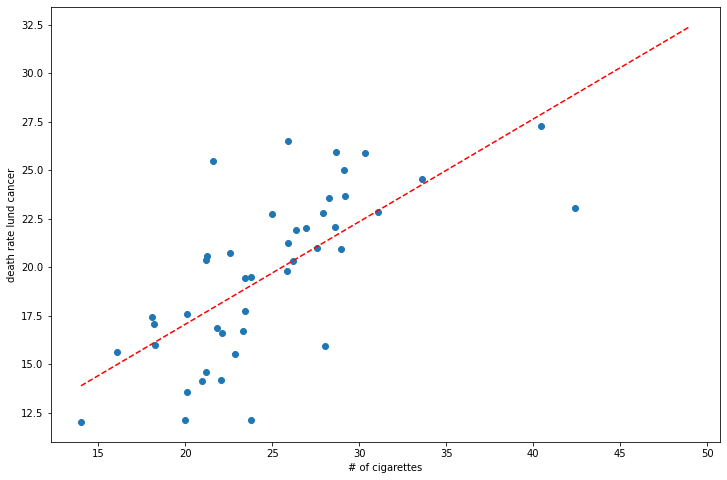

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression as LR

x = df.CIG.values  # NUmber of cigarettes smoked (hds pr capita)
y = df.LUNG.values  # Death per 100k population lung cancer

reg = LR().fit(x.reshape(-1,1), y)
intercept, coef = reg.intercept_, reg.coef_

x_val = np.arange(14,50,1)
x_fit = [i*coef + intercept for i in x_val]

plt.figure(figsize=(12,8))
plt.plot(x, y, 'o')
plt.plot(x_val, x_fit, 'r--')
plt.xlabel("# of cigarettes")
plt.ylabel("death rate lund cancer")
plt.show()

This is a linear regression model:

$$y = X\beta + \epsilon \qquad \text{where }\epsilon \sim N(0, \sigma^2 I_n)$$

where $I_n$ is the identity matrix. Our model will look like this:

$$y_i = x_{i,0}\beta_0 + x_{i,1}\beta_1 = intercept + x_{i,1}coef$$

The first part, $x_{i,0}$ is our "bias", iow only contains 1's. This is for the interception part of our model (where we want our value to be when x=0). The second part is what all our other x points should be, iow how much should our model increas/decrease with.

This will change the setup from Nils ex 22 a bit, but it is similar (we go from single points/scalars into the world of matrix calculations).

Our likelihood function will now look like this:

$$L_n(\beta, \sigma) = \sigma^{-n} exp\left[-\frac12 \frac{1}{\sigma^2}\big(Q_0 + n(\beta - \hat{\beta})^t M_n (\beta - \hat{\beta}) \big) \right]$$

Where 

$$M_n = \frac1n X^tX = N^{-1}\sum_{i=1}^n x_i x_i^t \quad \text{ and } \quad \hat{\beta} = (X^tX)^{-1}X^ty = M_n^{-1}n^{-1} \sum_{i=1}^nx_i y_i$$

and 

$$Q(\beta) = \|y - X\beta \|^2 = Q_0 + n(\beta - \hat{\beta})^t M_n (\beta - \hat{\beta})$$


Note that $Q_0 = \sum_{i=1}^n (y_i - x_i^t \hat{\beta})^2$, which is the __minimum value__ of $Q$ over all $\beta$. Also note that $\hat{\beta}$ is the classical least squartes estimator (and the ML, aka Maximum Likelihood, estimator), that we found above using Scikit-Learn's linear regression method.

Our prior looks like this:

$$(\lambda, \beta) \sim GN_k (a,b,\beta_0, M_0)$$

with:

$$\lambda = \frac{1}{\sigma^2} \sim Gamma(a,b) \quad \text{ and } \quad \beta | \sigma N_k(\beta_0, \sigma M_0^{-1})$$

From our prior $GN_k$ model and likelihood function, we'll get a posterior:

$$(\lambda, \beta)|data \sim GN_k\left(a+\frac12, b+ \frac12 Q_0 + \frac12(\hat{\beta}-\beta_0)^t D_n(\hat{\beta - \beta_0}), \beta^*, M_0 + nM_n\right)$$

where 
$$\beta^* = (M_0 + nM_n)^{-1}(M_0\beta_0 + nM_n\hat{\beta}) \quad \text{ and } \quad D_n = M_0(M_0 + nM_n)^{-1}nM_n$$

This is very simular to what we found in Nils exercise 22, but now we have the "Matrix variant".

__NOTE:__ when we go from working with scalars to working with matrices/vectors, we'll go from

* $\mu \rightarrow \beta$ 
* $v_0 \rightarrow M_0$, but now it is a matrix instead of a scalar. (may not be exactly the same...)
* $d_n \rightarrow D_n$

Also note that $a$ and $b$ is found using the same technique as in Nils exercise 22, we find it by using non-linear minimization.

Now that we have establised some good formulas, lets look at the task in Nils exercise 23h):

We are given a regression model that looks like this:

$$y_i = \alpha + \beta x_i + \epsilon_i \quad \text{for } i = 1, ..., 44$$

Where $\epsilon_i \sim N(0, \sigma^2)$ and iid. We want point estimates + 95% credibility interval of the three parameters $\alpha, \beta, \sigma$, the probability that $y \geq 25.0$ for a country with cigarette consumption x=35.0, AND the lung cancer death rates $y_{45}$ and $y_{46}$, per 100,000 inhabians, for coutries with cigarette consumption rates $x_{45} = 10.0$ (low) and $x_{46} = 50.0$ (high).


First, we are given the prior:

$$\frac{1}{\sigma^2} \sim Gamma(a,b)$$

where 0.10 and 0.90 quantiles for $\sigma$ equal to 1.0 and 5.0.

$\alpha$ and $\beta$ is independent normals:

$$\alpha \sim N(15.0, (2.0\sigma)^2) \qquad \text{ and } \qquad \beta \sim N(0.0, (2.0\sigma)^2)$$

Where $\sigma$ is given.

First we find our $a_0$ and $b_0$ using minimazation:

In [3]:
import scipy.stats as stats
import scipy.optimize as opti

sigma_low = 1.0
sigma_high = 5.0

def Q(params):
    '''
    This is defined in Nils 23 (I think)
    '''
    a = params[0]
    b = params[1]
    
    upper = 1 - stats.gamma.cdf(1/sigma_high**2, a, scale=1/b) - 0.90
    lower = 1 - stats.gamma.cdf(1/sigma_low**2, a, scale=1/b) - 0.10
    
    return upper**2 + lower**2

minimize = opti.minimize(Q, [3.0, 4.0])

a0, b0 = minimize["x"]

print(a0, b0)
# check that we get the right probabilities
print(1 - stats.gamma.cdf(x=1/(sigma_low**2), a=a0, scale=1/b0))  # should be 0.1
print(1 - stats.gamma.cdf(x=1/(sigma_high**2), a=a0, scale=1/b0))  # should be 0.9

0.939483462409857 2.1967257952160177
0.09999926532259573
0.8999998649795682


Both high and low have now a $a_0$ and $b_0$ that gives us gamma prob of 0.10 and 0.90, respectfully.

As we can see from our two normal formulas:

$$\alpha \sim N(15.0, (2.0\sigma)^2) \qquad \text{ and } \qquad \beta \sim N(0.0, (2.0\sigma)^2)$$

we have 2 in front of $\sigma$. This is our $M_0^{-1}$, which makes $M_0^{-1} = (2^{-1})^2 = \frac{1}{2^2}$. 

Our __X__ is a $44 \times 2$ matrix, that looks like this:

\begin{align*}
 X = 
 \begin{bmatrix}
 1 & x_1 \\
 1 & x_2 \\
 \vdots & \vdots \\
 1 & x_{44}
 \end{bmatrix}
\end{align*}

Where the first column is for our bias (or $\alpha$) and the second column is for our observations (our $\beta$). This can be used to calcualte:

$$M_n = \frac{1}{n} X^TX$$

The last thing we need to update our parameters is $D_n$. This is done with the formula:

$$D_n = M_0(M_0 + nM_n)^{-1}nM_n$$

We will now estabilish our prior mean with our ML (maximum likelihood) and prior precisions:

In [4]:
n = len(y)
Q0 = sum((y - (intercept + coef*x))**2)  # same as in Nils ex 22, used in b update

# prior mean (given in ex 23h)
beta0 = np.array([15.0, 0.0]).reshape(-1,1)  # prior mean
ML = np.array([intercept, coef[0]]).reshape(-1,1)  # aka beta hat

c0 = 1/2.0**2  # I think this represents the same thing as v did in Nils ex 22
M0 = c0 * np.identity(2)

ones = np.ones(n)
x_mat = np.transpose(np.array([ones, x]))  # first part is for alpha and second part is for beta (bias and observation)
Mn = 1/n * np.matmul(np.transpose(x_mat), x_mat)
Dn = np.matmul(np.matmul(M0, np.linalg.inv(M0 + n*Mn)), n*Mn)

__NOTE__ that our $\hat{\beta}$ is unbiased with covariance matrix equal to $\sigma^2 (X^tX)^{-1} = \frac{\sigma^2}{n}M_n^{-1}$.

Posterior model:

$$(\lambda, \beta)|data \sim GN_k\left(a+\frac12, b+ \frac12 Q_0 + \frac12(\hat{\beta}-\beta_0)^t D_n(\hat{\beta - \beta_0}), \beta^*, M_0 + nM_n\right)$$

where

$$\beta^* = (M_0 + nM_n)^{-1}(M_0\beta_0 + nM_n\hat{\beta})$$

Now we got everything we need to update our parameters, and go from a prior to a posterior model.

In [5]:
a_new = a0 + 0.5*n
b_new = b0 + 0.5*Q0 + 0.5*np.matmul(np.transpose(ML-beta0), np.matmul(Dn, (ML-beta0)))
beta_star = np.matmul(np.linalg.inv(M0 + n*Mn), (np.matmul(M0, beta0) + n*np.matmul(Mn,ML)))
V = np.linalg.inv(M0 + n*Mn) # I think that this is the covariance matrix

sigma1 = np.sqrt(V[0,0])  
sigma2 = np.sqrt(V[1,1])

corr = V[0,1]/(sigma1*sigma2)

print(f"Covariance matrix posterior:\n{V}\n\n")
print(f"Prior:\nGN{a0, b0, beta0, M0}")
print(f"Posterior:\nGN({a_new, b_new[0][0], beta_star, V})")

Covariance matrix posterior:
[[ 0.43443585 -0.01662421]
 [-0.01662421  0.00067105]]


Prior:
GN(0.939483462409857, 2.1967257952160177, array([[15.],
       [ 0.]]), array([[0.25, 0.  ],
       [0.  , 0.25]]))
Posterior:
GN((22.939483462409857, 207.7476791877081, array([[7.40013644],
       [0.49354506]]), array([[ 0.43443585, -0.01662421],
       [-0.01662421,  0.00067105]])))


In [6]:
print(f"Correlation between our sigmas after update:\n{corr}")

Correlation between our sigmas after update:
-0.9736432158845254


The correlation is close to -1 (meaning almost perfect correlation). Now that we have established our posterior distribution, we can now start to simulate.

First we're gonna simulate to find $\sigma$. We know $\sigma$ is defined as:

$$\lambda = \frac{1}{\sigma^2} \sim Gamma(a,b)$$

This means $\sigma$ is:

$$\sigma \sim \frac{1}{\sqrt{Gamma(a,b)}}$$

In [8]:
sim = 10**5
sigma_sim = 1/np.sqrt(stats.gamma.rvs(a=a_new, scale=1/b_new, size=sim))

sigma_estimate = np.mean(sigma_sim)
print(f"Point estimate sigma: {sigma_estimate}\n95% credibility interval:\n{np.quantile(sigma_sim, [0.025, 0.975])} ")

Point estimate sigma: 3.060208102296824
95% credibility interval:
[2.50389009 3.7784968 ] 


Now that we have gotten an estimate for $\sigma$, we can now estimate $\alpha$ and $\beta$. Recall that

This is done by using our updated mean vector, $\beta^*$, and create a randomly distributed numbers, based on the equation:

$$\beta | \sigma \sim N(\beta^*, \sigma^2 (M_0 + nM_n)^{-1})$$

Here refers to all $\beta$ in the linear regression model. This will give two normal distibutions, one for $\alpha$ and one for $\beta$:

$$\alpha \sim N(\beta_0^*, \sigma^2 (M_0 + nM_n)_{0,0}^{-1}) \quad \text{ and } \quad \beta \sim N(\beta_1^*, \sigma^2 (M_0 + nM_n)_{1,1}^{-1})$$

In [9]:
rand_norm_alpha = stats.norm.rvs(size=sim)
rand_norm_beta = stats.norm.rvs(size=sim)
alpha_sim = beta_star[0] + np.sqrt(V[0,0])*sigma_sim*rand_norm_alpha#(corr*rand_norm_beta + np.sqrt(1-corr**2)*rand_norm_alpha)
beta_sim = beta_star[1] + np.sqrt(V[1,1])*sigma_sim*(corr*rand_norm_alpha + np.sqrt(1-corr**2)*rand_norm_beta)

alpha_estimate = np.mean(alpha_sim)
beta_estimate = np.mean(beta_sim)

print(f"Point estimate alpha: {alpha_estimate}\n95% credibility interval:\n{np.quantile(alpha_sim, [0.025, 0.975])}\n")
print(f"Point estimate beta: {beta_estimate}\n95% credibility interval:\n{np.quantile(beta_sim, [0.025, 0.975])} ")

Point estimate alpha: 7.389120913471653
95% credibility interval:
[ 3.40355856 11.38588386]

Point estimate beta: 0.4940206093528217
95% credibility interval:
[0.33741607 0.65065296] 


Now that we have gotten the point estimates and credibility intervals for $\sigma, \alpha, \beta$, lets do the same thing with 

$$Pr(y \geq 25.0 | x=35.0)$$

iow:

$$\gamma = Pr(y \geq 25.0 | x=35.0) = 1 - Pr\left(z \leq \frac{y_0 - (\alpha + \beta \cdot x_0)}{\sigma}\right)$$

In [10]:
x0 = 35
y0 = 25

gamma_sim = 1 - stats.norm.cdf((y0 - (alpha_sim + beta_sim*x0))/sigma_sim)
print(f"Point estimat gamma: {np.mean(gamma_sim)}")
print(f"95% credibility interval: {np.quantile(gamma_sim, [0.025, 0.975])}")

Point estimat gamma: 0.45971231210042296
95% credibility interval: [0.24223489 0.68924252]


What about future observations $y_{45}$ and $y_{46}$!? What will be their expected death rates given that their cigarette consumptions is $x_{45} = 10.0$ (low) and $x_{46} = 50.0$ (high)?

Lets have a look, we use our simulated $\alpha, \beta$ and $\sigma$ to simulate our predictions:

In [11]:
x45 = 10.0 # a low value of cigarette consumption
y45 = alpha_sim + beta_sim*x45 + sigma_sim*stats.norm.rvs(size=sim)

x46 = 50.0 # a high value of cigarette consumption
y46 = alpha_sim + beta_sim*x46 + sigma_sim*stats.norm.rvs(size=sim)

print(f"Expected lung cancer death rates when consumption is low (10.0): {round(np.mean(y45), 5)}")
print(f"95% credibility interval lung cancer death rates when consumption is low (10.0):\n{np.quantile(y45, [0.025, 0.975])}\n")

print(f"Expected lung cancer death rates when consumption is high (50.0): {round(np.mean(y46), 5)}")
print(f"95% credibility interval lung cancer death rates when consumption is high (10.0):\n{np.quantile(y46, [0.025, 0.975])}")


Expected lung cancer death rates when consumption is low (10.0): 12.32113
95% credibility interval lung cancer death rates when consumption is low (10.0):
[ 5.78008173 18.88680166]

Expected lung cancer death rates when consumption is high (50.0): 32.08778
95% credibility interval lung cancer death rates when consumption is high (10.0):
[24.80882392 39.37024699]


___

__NOTE:__ Still missing the last two exercises in Nils exeercise 23h), need to do later if time.